In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [21]:
# Fetch Nifty 50 data from yfinance with ticker fallback
tickers = ['^NSEI', 'NIFTY_50.NS', '^NIFTY50']
nifty = None
for ticker in tickers:
    try:
        nifty = yf.download(ticker, start='2020-01-01', end='2024-12-31')
        if not nifty.empty:
            print(f"Successfully retrieved data for ticker: {ticker}")
            break
    except Exception as e:
        print(f"Failed to retrieve data for {ticker}: {e}")
if nifty is None or nifty.empty:
    raise ValueError("No data retrieved from yfinance for any ticker. Check tickers or network connection.")
print(f"DataFrame shape: {nifty.shape}")
print(f"Raw columns: {list(nifty.columns)}")

[*********************100%***********************]  1 of 1 completed

Successfully retrieved data for ticker: ^NSEI
DataFrame shape: (1236, 5)
Raw columns: [('Close', '^NSEI'), ('High', '^NSEI'), ('Low', '^NSEI'), ('Open', '^NSEI'), ('Volume', '^NSEI')]


In [22]:
# Handle MultiIndex columns and normalize column names
if isinstance(nifty.columns, pd.MultiIndex):
    for level in range(nifty.columns.nlevels):
        cols = nifty.columns.get_level_values(level)
        print(f"MultiIndex level {level}: {list(cols)}")
        if any(col.lower() in ['open', 'high', 'low', 'close', 'volume'] for col in cols):
            nifty.columns = cols
            break
else:
    nifty.columns = nifty.columns.astype(str)

# Normalize column names to expected format
column_mapping = {
    'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume',
    'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Close': 'Close', 'Volume': 'Volume'
}
nifty.columns = [column_mapping.get(col.lower(), col) for col in nifty.columns]
print(f"Normalized columns: {list(nifty.columns)}")

# Validate expected columns
expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
missing_cols = [col for col in expected_columns if col not in nifty.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")
data = nifty[expected_columns].copy()
print("Data collection and column validation completed.")

MultiIndex level 0: ['Close', 'High', 'Low', 'Open', 'Volume']
Normalized columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data collection and column validation completed.


In [23]:
# Clean and normalize data
data = data.dropna()
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna()
data['Open'] = (data['Open'] - data['Open'].mean()) / data['Open'].std()
data['High'] = (data['High'] - data['High'].mean()) / data['High'].std()
data['Low'] = (data['Low'] - data['Low'].mean()) / data['Low'].std()
data['Close'] = (data['Close'] - data['Close'].mean()) / data['Close'].std()
data['Volume'] = (data['Volume'] - data['Volume'].mean()) / data['Volume'].std()
print("Data preprocessing completed.")

Data preprocessing completed.


In [ ]:
# Technical indicators and additional features
data['SMA_20'] = ta.sma(data['Close'], length=20)
data['SMA_50'] = ta.sma(data['Close'], length=50)
data['RSI'] = ta.rsi(data['Close'], length=14)
macd_ind = ta.macd(data['Close'], fast=12, slow=26, signal=9)
if macd_ind is None:
    print("Warning: MACD calculation failed. Filling with zeros.")
    data['MACD'] = 0
    data['MACD_Signal'] = 0
else:
    data['MACD'] = macd_ind['MACD_12_26_9']
    data['MACD_Signal'] = macd_ind['MACDs_12_26_9']
data['Volatility_10d'] = data['Close'].rolling(window=10).std()
data['ADX'] = ta.adx(data['High'], data['Low'], data['Close'], length=14)['ADX_14']
np.random.seed(42)
data['Sentiment_Score'] = np.random.uniform(-1, 1, len(data))
data['Sentiment_Momentum'] = data['Sentiment_Score'].diff()
data['Budget_Day'] = 0
data.loc['2021-02-01', 'Budget_Day'] = 1
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data.dropna(inplace=True)
print(f"Feature engineering completed. Final DataFrame shape: {data.shape}")

Feature engineering completed. Final DataFrame shape: (1187, 16)


In [ ]:
# Handling the outliers in feature columns
for feature in ['SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Volatility_10d', 'ADX', 'Sentiment_Score', 'Sentiment_Momentum']:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[feature] = data[feature].clip(lower_bound, upper_bound)

In [ ]:
# Model training 
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'Volatility_10d', 
            'ADX', 'Sentiment_Score', 'Sentiment_Momentum', 'Budget_Day']
X = data[features]
y = data['Trend']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Hyperparameter tuning for Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
lr_model = grid_search.best_estimator_
print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")

# Save models and scaler
joblib.dump(lr_model, "nifty_trend_lr_model_scaled.pkl")
joblib.dump(rf_model, "nifty_trend_rf_model_scaled.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Modeling completed. Models and scaler saved.")

Best parameters for Logistic Regression: {'C': 0.001}
Modeling completed. Models and scaler saved.


In [27]:
# Evaluate models with metrics and cross-validation
y_pred_lr = lr_model.predict(X_test_scaled)
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.2f}")

y_pred_rf = rf_model.predict(X_test_scaled)
print("\nRandom Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")

# Cross-validation for Logistic Regression
cv_scores_lr = cross_val_score(lr_model, X_scaled, y, cv=5)
print(f"Logistic Regression CV Scores: {cv_scores_lr}")
print(f"Average CV Score: {cv_scores_lr.mean():.2f} (+/- {cv_scores_lr.std() * 2:.2f})")

Logistic Regression Metrics:
Accuracy: 0.55
Precision: 0.55
Recall: 1.00
F1 Score: 0.71

Random Forest Metrics:
Accuracy: 0.45
Precision: 0.50
Recall: 0.21
F1 Score: 0.29
Logistic Regression CV Scores: [0.55882353 0.55882353 0.56118143 0.56118143 0.57383966]
Average CV Score: 0.56 (+/- 0.01)


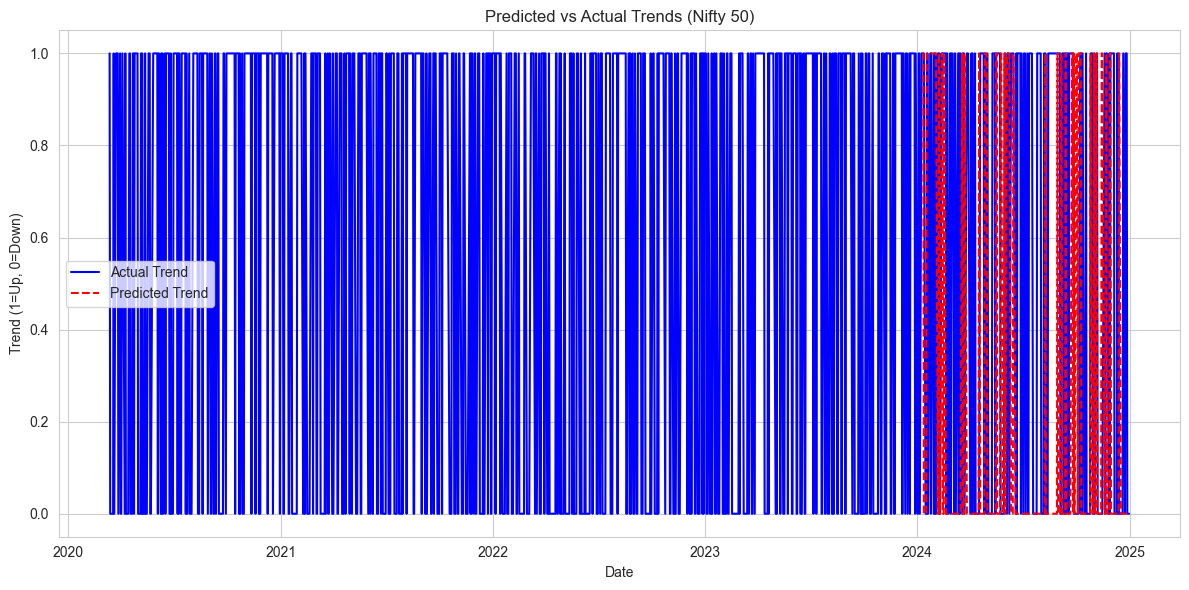

In [ ]:
# Visualizations 
%matplotlib inline
sns.set_style("whitegrid")

# Verify required variables are defined
if 'data' not in globals() or 'y_test' not in globals() or 'y_pred_rf' not in globals():
    raise ValueError("Required variables (data, y_test, y_pred_rf) are not defined. Run previous cells.")

# Add Random Forest predictions to the DataFrame
data['Predicted'] = np.nan
test_indices = data.index[-len(y_test):]
data.loc[test_indices, 'Predicted'] = y_pred_rf  # Use Random Forest predictions

# Plot 1: Predicted vs Actual Trends (Seaborn/Matplotlib)
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Trend'], label='Actual Trend', color='blue', linestyle='-')
sns.lineplot(x=data.index, y=data['Predicted'], label='Predicted Trend', color='red', linestyle='--')
plt.title('Predicted vs Actual Trends (Nifty 50)')
plt.xlabel('Date')
plt.ylabel('Trend (1=Up, 0=Down)')
plt.legend()
plt.tight_layout()
plt.show()


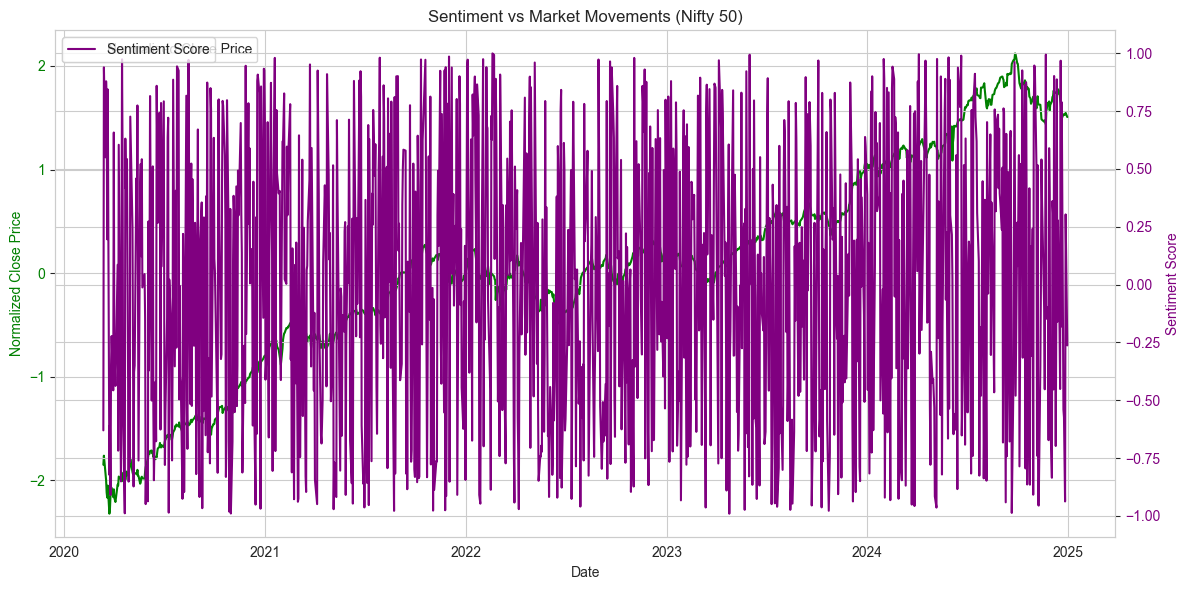

In [31]:

# Plot 2: Sentiment vs Market Movements (Seaborn/Matplotlib with Dual Axes)
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Close'], label='Normalized Close Price', color='green', ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Close Price', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()  # Create second y-axis
sns.lineplot(x=data.index, y=data['Sentiment_Score'], label='Sentiment Score', color='purple', ax=ax2)
ax2.set_ylabel('Sentiment Score', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Sentiment vs Market Movements (Nifty 50)')
fig.tight_layout()
plt.show()


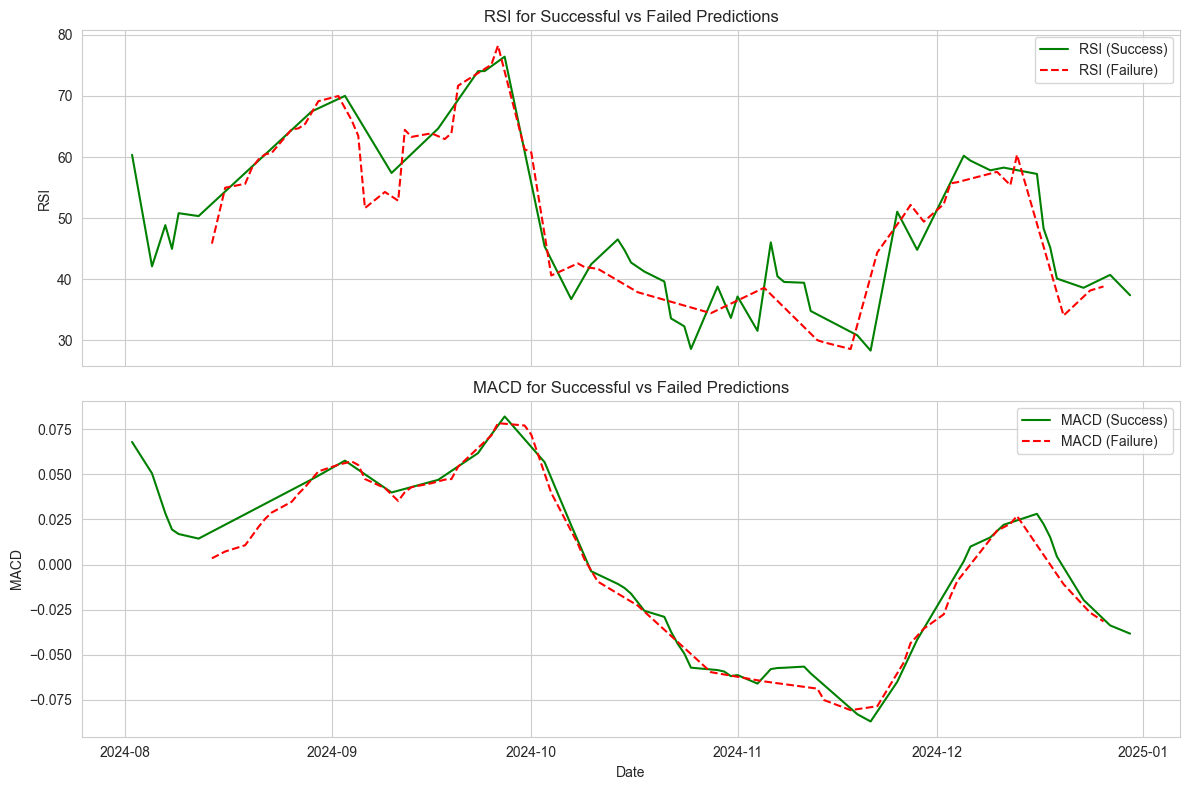

In [32]:

# Plot 3: Indicator Movements on Successful/Failed Predictions (Matplotlib with Seaborn Style)
data['Correct'] = data['Trend'] == data['Predicted']
success_df = data[data['Correct'] == True].tail(50)
failure_df = data[data['Correct'] == False].tail(50)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(success_df.index, success_df['RSI'], 'g-', label='RSI (Success)')
axes[0].plot(failure_df.index, failure_df['RSI'], 'r--', label='RSI (Failure)')
axes[0].set_title('RSI for Successful vs Failed Predictions')
axes[0].set_ylabel('RSI')
axes[0].legend()

axes[1].plot(success_df.index, success_df['MACD'], 'g-', label='MACD (Success)')
axes[1].plot(failure_df.index, failure_df['MACD'], 'r--', label='MACD (Failure)')
axes[1].set_title('MACD for Successful vs Failed Predictions')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('MACD')
axes[1].legend()

plt.tight_layout()
plt.show()

In [34]:
# Save the processed dataset
data.to_csv('nifty50_dataset.csv')
print("Visualizations and dataset saved.")

Visualizations and dataset saved.
